In [44]:
import numpy as np
import tensorflow as tf 

### **Positional Encoding**  

Transformer는 입력 시퀀스를 병렬적으로 처리하기 때문에, 입력 데이터는 위치정보를 포함하고 있어야 한다.  
Positional Encoding은 각 입베딩 벡터에 위치 정보를 더하는 과정이다.  

In [90]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, N, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.get_positional_encoding(N, d_model)
    
    def get_positional_encoding(self, N, d_model):

        def get_pos_formular(pos, i, d_model):
            formular = pos / tf.math.pow(10000, 2*i / tf.cast(d_model, tf.float32))
            return tf.math.sin(formular) if i%2 is 0 else tf.math.cos(formular)

        pos_encoding = [[get_pos_formular(pos, i, d_model) for i in range(d_model)] for pos in range(N)]
        pos_encoding = np.array(pos_encoding)

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding

아래는 50개의 임베딩 벡터, 각 임베딩 벡터의 차원이 128일 때의 포지셔널 인코딩 행렬을 시각화한 것이다.

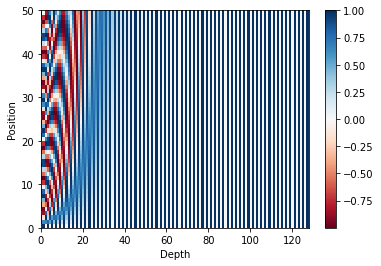

In [91]:
import matplotlib.pyplot as plt

pos_encoder = PositionalEncoding(50, 128)

plt.pcolormesh(pos_encoder.pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### **Padding Mask 생성**  
softmax 함수에 잘못된 값이 들어가는 경우에, 이 값을 연산에서 제외하기 위해 Padding Mask 단계를 거친다.  
mask에 -1e9 값을 곱해 Attention Score 행렬에 더한다.

In [46]:
def create_padding_mask(multiple_qk):
    mask = tf.cast(tf.math.equal(multiple_qk.numpy(),0), tf.float32)
    return mask * -1e9

In [115]:
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  
print(create_padding_mask(temp_k))

tf.Tensor(
[[-0.e+00 -1.e+09 -1.e+09]
 [-1.e+09 -0.e+00 -1.e+09]
 [-1.e+09 -1.e+09 -0.e+00]
 [-1.e+09 -1.e+09 -0.e+00]], shape=(4, 3), dtype=float32)


### **Scaled Dot-product Attention**  
Dot-product Attention과 유사하나, k 벡터의 차원 값인 d_k의 루트 값을 나눠 scaling하는 과정이 추가되었다.

```
Attention(Q, K, V) = softmax(Q*K^T)*V               # Dot-product Attention
Attention(Q, K, V) = softmax((Q*K^T)/sqrt(d_k))*V   # Scaled Dot-product Attention
```

In [110]:
def scaled_dot_product_attention(query, key, value, mask):

    print("Query type\t: {type}, Query Shape\t: {shape}".format(type=type(query),
                                                              shape=query.shape))
    print("Key type\t: {type}, Key Shape\t: {shape}".format(type=type(key),
                                                              shape=key.shape))
    print("Value type\t: {type}, Value Shape\t: {shape}\n".format(type=type(value),
                                                              shape=value.shape))

    # Attention Score : Q * K^T
    attention_score_matrix = tf.matmul(query, key, transpose_b=True)
    
    # Scaling : Divide by sqrt(d_k)
    d_k = tf.cast(key.shape[-1], tf.float32)
    scaled_matrix = attention_score_matrix / tf.math.sqrt(d_k)

    # Padding Mask
    padd_mask = mask if mask is not None else create_padding_mask(scaled_matrix)
    scaled_matrix += padd_mask

    # Softmax fuction
    attention_weights = tf.nn.softmax(scaled_matrix, axis=-1)

    # Weighted Sum : multiply V matrix
    attention_value = tf.matmul(attention_weights, value)

    return attention_value, attention_weights

아래는 `temp_k`, `temp_v`, `temp_q`가 입력으로 주어졌을 때 Attention Value와 Attention Distribution 을 구한 결과이다.

In [111]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  

In [112]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print("Attention Distribution : {}".format(temp_attn)) 
print("Attention Value : {}".format(temp_out))

Query type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Query Shape	: (1, 3)
Key type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Key Shape	: (4, 3)
Value type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Value Shape	: (4, 2)

Attention Distribution : [[0. 1. 0. 0.]]
Attention Value : [[10.  0.]]


### **Muti-Head Attention**  
한번의 Attention을 수행하는 것보다, 여러번의 Attention을 병렬적으로 수행하는 것이 효율적이다.  
각 Attention을 수행한 결과로부터 각기 다른 관점의 정보를 수집할 수 있다.  

In [116]:
class MultiHeadAttention:
    def __init__(self, num_heads, d_model):
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0, "depth가 정수 형식이 아닙니다."
        self.depth = self.d_model // self.num_heads

        # Dense 층의 출력 차원은 d_model
        self.WQ = tf.keras.layers.Dense(units=self.d_model)
        self.WK = tf.keras.layers.Dense(units=self.d_model)
        self.WV = tf.keras.layers.Dense(units=self.d_model)
        self.WO = tf.keras.layers.Dense(units=self.d_model)

    
    def get_multi_head_attention(self, query, key, value):

        def split_sequences(num_heads, d_model, query, key, value):
            Q_list = np.reshape(query, (-1, num_heads, d_model // num_heads))
            K_list = np.reshape(key, (-1, num_heads, d_model // num_heads))
            V_list = np.reshape(value, (-1, num_heads, d_model // num_heads))

            print("Q shape : {q}, K shape : {k}, V shape : {v}\n".format(q=Q_list.shape, k=K_list.shape, v=V_list.shape))
            return Q_list, K_list, V_list
            
        def get_single_attention(Qi, Ki, Vi):
            q_WQ = self.WQ(Qi)
            k_WK = self.WK(Ki)
            v_WV = self.WV(Vi)
        
            head, _ = scaled_dot_product_attention(q_WQ, k_WK, v_WV, None)
            return head

        def concatenate_heads(heads):
            return np.concatenate(heads, axis=1)
        
        Q_list, K_list, V_list = split_sequences(self.num_heads, self.d_model, query, key, value)
        heads = [get_single_attention(query, key, value) for num in range(self.num_heads)]
        concat_heads = concatenate_heads(heads)

        result = self.WO(concat_heads)

        return result
        
        

In [115]:
temp_k = tf.constant([[10,0,0,10,0,0,10,0,0,10,0,0,10,0,0,1],
                      [0,10,0,0,10,0,0,10,0,0,10,0,0,10,0,1],
                      [0,0,10,0,0,10,0,0,10,0,0,10,0,0,10,1],
                      [0,0,10,0,0,10,0,0,10,0,0,10,0,0,10,1]], dtype=tf.float32)  

temp_v = tf.constant([[   1,0,    1,0],
                      [  10,0,   10,0],
                      [ 100,5,  100,5],
                      [1000,6, 1000,6]], dtype=tf.float32)  

temp_q = tf.constant([[0, 10, 0,0, 10, 0,0, 10, 0,0, 10, 0,0, 10, 0,1]], dtype=tf.float32)

attention = MultiHeadAttention(4, 16)
result =attention.get_multi_head_attention(temp_q, temp_k, temp_v)
print("Attention Value : {}".format(result))
print(result.shape)

Q shape : (1, 4, 4), K shape : (4, 4, 4), V shape : (1, 4, 4)
Query type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Query Shape	: (1, 16)
Key type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Key Shape	: (4, 16)
Value type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Value Shape	: (4, 16)

Query type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Query Shape	: (1, 16)
Key type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Key Shape	: (4, 16)
Value type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Value Shape	: (4, 16)

Query type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Query Shape	: (1, 16)
Key type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Key Shape	: (4, 16)
Value type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Value Shape	: (4, 16)

Query type	: <class 'tensorflow.python.framework.ops.EagerTensor'>, Query Shape	: (1, 16)
Key type	: <class 'tensorflow.python.framework.